In [1]:
import json
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import sys
sys.path.append('../')
from Misc import syn_data_gen, save_load_files
from GPCollabPrefAct import collab_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
num_data = 20
# Specific occupants 6, 7, 8 actions
specific_occ_actions_data_list = []
specific_occ_actions_data_norm_list = []
for i in xrange(5,8):
    occ_num = i + 1
    print "Occupant number:"
    print occ_num
    config_file = '../data/config_files/syn/diff_utilities_config/syn_occupants.json'
    with open(config_file, 'r') as fd:
        config = json.loads(fd.read())

    a = config['O' + str(occ_num)]['a']
    b = config['O' + str(occ_num)]['b']
    
    # Load actions data
    actions_data = np.loadtxt('../data/syn_data/syn_occ/actions_data/train/' +
                         'O_a' + str(a) + '_b' + str(b) + '_' + str(num_data) + '_.csv', delimiter = ',')
    
    actions_data_norm = (actions_data - 0.5)/0.5
    
    specific_occ_actions_data_list.append(actions_data)
    specific_occ_actions_data_norm_list.append(actions_data_norm) 

all_x_grid = np.linspace(0,1,50)

Occupant number:
6
Occupant number:
7
Occupant number:
8


In [3]:
all_x_grid = np.linspace(0,1,50)
all_x_grid_norm = (all_x_grid - 0.5)/0.5

# Collaborative Preference Learning Model Setup

In [4]:
latent_gps_kerns_list = [gpflow.kernels.RBF(1), gpflow.kernels.RBF(1), gpflow.kernels.RBF(1)]

In [5]:
#def __init__(self, actions_list, kerns_list, X_grid)
m = collab_gpmc.GPCollabPrefLearnGPMC(specific_occ_actions_data_norm_list, latent_gps_kerns_list, all_x_grid_norm)

In [6]:
for i in xrange(len(latent_gps_kerns_list)):
    m.kerns_list[i].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
    m.kerns_list[i].variance.prior = gpflow.priors.Gamma(1., 1.)

In [7]:
m.X_grid.value.shape

(50, 1)

In [8]:
m.concat_ind_cur_prev_mat.shape

(3, 40)

In [9]:
m.optimize(maxiter=5000) # start near MAP

U shape:
Tensor("collaborative_pref_gps.build_likelihood/MatMul_3:0", shape=(3, ?), dtype=float64)
concerned_mat shape:
Tensor("collaborative_pref_gps.build_likelihood/transpose_4:0", shape=(3, 40), dtype=float64)
U_diff
Tensor("collaborative_pref_gps.build_likelihood/Sub:0", shape=(3, 20), dtype=float64)
flatten_U_diff
Tensor("collaborative_pref_gps.build_likelihood/Reshape_80:0", shape=(60, 1), dtype=float64)
y
Tensor("Y:0", shape=(?, ?), dtype=float64)


      fun: array([ 163.8572213])
 hess_inv: <156x156 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.92070890e-04,   1.68367749e-04,  -1.37360864e-04,
         2.07200132e-05,  -2.03146988e-05,  -1.76598132e-04,
        -2.30070258e-04,  -2.08996156e-04,  -1.84592112e-04,
        -1.88996473e-04,  -1.47850742e-04,  -5.95076031e-05,
        -3.01951304e-05,  -8.03073125e-05,  -9.44412472e-05,
        -1.52397215e-05,   4.47456471e-05,   1.59655555e-05,
        -2.47356243e-05,  -2.15800884e-05,  -3.59657138e-06,
        -8.96364528e-06,  -7.93949320e-06,   1.02441926e-05,
         2.82730588e-05,   3.37495758e-05,   3.23639344e-05,
         2.98365142e-05,   2.71779273e-05,   3.12013622e-05,
         3.57699016e-05,   4.02561314e-05,   3.89730486e-05,
         4.63248252e-05,   5.08820024e-05,   5.34456919e-05,
         5.08848843e-05,   4.45078371e-05,   3.31411204e-05,
         1.88535424e-05,   6.70804692e-06,  -3.04646327e-06,
        -8.26497472e-06,  -6.67561416e-06,

In [10]:
m

Name,values,prior,constraint
collaborative_pref_gps.V_h,[[ -9.82520991e-01 -2.39943092e-01 -3.51982565e-02 2.17108709e-02 6.25529331e-02 8.31582264e-02 1.05251220e-01 1.22052387e-01 1.17980886e-01 1.15513366e-01 1.15381603e-01 1.31640319e-01 1.73179706e-01 2.29734842e-01 3.09611089e-01 3.71340898e-01 4.45167478e-01 4.97359701e-01 5.30360054e-01 5.23174917e-01 4.87988802e-01 4.22811851e-01 3.39649605e-01 2.47902584e-01 1.40178369e-01 3.18360790e-02 -5.64813160e-02 -1.28719406e-01 -1.90455472e-01 -2.27854403e-01 -2.46484351e-01 -2.44271324e-01 -2.32364112e-01 -1.96888141e-01 -1.57156714e-01 -1.12695311e-01 -7.23664383e-02 -3.06268301e-02 1.14212738e-03 2.63275590e-02 4.24630669e-02 4.82541180e-02 4.42311168e-02 3.90059610e-02 2.43924342e-02 1.27257240e-02 5.87667363e-03 -9.81174399e-04 0.00000000e+00 0.00000000e+00] [ -1.93886214e-01 1.84800023e-01 4.48916107e-01 4.09706293e-01 4.67458312e-01 5.51865672e-01 5.26934473e-01 4.74312464e-01 4.41913651e-01 4.04350673e-01 3.29039878e-01 2.53651617e-01 1.85943577e-01 1.28942603e-01 7.55846392e-02 3.00419924e-02 -2.76739689e-03 -4.62153275e-02 -5.90073389e-02 -7.36825063e-02 -7.35156152e-02 -8.52448913e-02 -8.53810471e-02 -7.67036354e-02 -7.80280821e-02 -7.23503210e-02 -8.00697678e-02 -9.48316258e-02 -1.14205802e-01 -1.53234968e-01 -1.96654014e-01 -2.37472546e-01 -2.78057563e-01 -3.10464444e-01 -3.32135208e-01 -3.41116242e-01 -3.36420118e-01 -3.15883028e-01 -2.93526463e-01 -2.53420859e-01 -2.00188667e-01 -1.60139519e-01 -1.17029713e-01 -8.66266039e-02 -4.93892606e-02 -2.76860793e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [ 5.44137570e-01 8.52821062e-01 3.55200315e-01 3.30089669e-01 2.16529333e-01 1.56963187e-01 1.35772860e-01 1.11445170e-01 9.20158655e-02 7.49986681e-02 6.47953354e-02 5.89940098e-02 5.53689952e-02 4.67838766e-02 2.97683238e-02 1.81653344e-02 1.29840275e-02 -1.08448136e-02 -3.78693478e-02 -6.74118655e-02 -9.82805426e-02 -1.35774271e-01 -1.70656815e-01 -2.06180386e-01 -2.42387977e-01 -2.68892339e-01 -2.96989532e-01 -3.19262399e-01 -3.35708722e-01 -3.46764993e-01 -3.42902273e-01 -3.47996534e-01 -3.32170514e-01 -3.11979236e-01 -2.88394852e-01 -2.61730346e-01 -2.36614833e-01 -1.98979538e-01 -1.75655847e-01 -1.47513696e-01 -1.12741581e-01 -8.95939837e-02 -6.46271422e-02 -5.42570372e-02 -3.89008059e-02 -1.46787853e-02 -1.08681810e-02 -1.78318601e-03 -1.11743355e-03 -8.35305525e-04]],"N([ 0.],[ 1.])",(none)
collaborative_pref_gps.kerns_list.item0.lengthscales,[ 0.24807198],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item0.variance,[ 2.02194438],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item1.lengthscales,[ 0.30041598],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item1.variance,[ 1.88888067],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item2.lengthscales,[ 0.42395351],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item2.variance,[ 1.77509225],"Ga([ 1.],[ 1.])",+ve


In [11]:
samples = m.sample(500, verbose=True, epsilon=0.05, thin = 2, burn = 500, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  97.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  98.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  97.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  99.0 %
Iteration:  700 	 Acc Rate:  97.0 %
Iteration:  800 	 Acc Rate:  99.0 %
Iteration:  900 	 Acc Rate:  99.0 %
Iteration:  1000 	 Acc Rate:  99.0 %


In [12]:
m

Name,values,prior,constraint
collaborative_pref_gps.V_h,[[ -9.82520991e-01 -2.39943092e-01 -3.51982565e-02 2.17108709e-02 6.25529331e-02 8.31582264e-02 1.05251220e-01 1.22052387e-01 1.17980886e-01 1.15513366e-01 1.15381603e-01 1.31640319e-01 1.73179706e-01 2.29734842e-01 3.09611089e-01 3.71340898e-01 4.45167478e-01 4.97359701e-01 5.30360054e-01 5.23174917e-01 4.87988802e-01 4.22811851e-01 3.39649605e-01 2.47902584e-01 1.40178369e-01 3.18360790e-02 -5.64813160e-02 -1.28719406e-01 -1.90455472e-01 -2.27854403e-01 -2.46484351e-01 -2.44271324e-01 -2.32364112e-01 -1.96888141e-01 -1.57156714e-01 -1.12695311e-01 -7.23664383e-02 -3.06268301e-02 1.14212738e-03 2.63275590e-02 4.24630669e-02 4.82541180e-02 4.42311168e-02 3.90059610e-02 2.43924342e-02 1.27257240e-02 5.87667363e-03 -9.81174399e-04 0.00000000e+00 0.00000000e+00] [ -1.93886214e-01 1.84800023e-01 4.48916107e-01 4.09706293e-01 4.67458312e-01 5.51865672e-01 5.26934473e-01 4.74312464e-01 4.41913651e-01 4.04350673e-01 3.29039878e-01 2.53651617e-01 1.85943577e-01 1.28942603e-01 7.55846392e-02 3.00419924e-02 -2.76739689e-03 -4.62153275e-02 -5.90073389e-02 -7.36825063e-02 -7.35156152e-02 -8.52448913e-02 -8.53810471e-02 -7.67036354e-02 -7.80280821e-02 -7.23503210e-02 -8.00697678e-02 -9.48316258e-02 -1.14205802e-01 -1.53234968e-01 -1.96654014e-01 -2.37472546e-01 -2.78057563e-01 -3.10464444e-01 -3.32135208e-01 -3.41116242e-01 -3.36420118e-01 -3.15883028e-01 -2.93526463e-01 -2.53420859e-01 -2.00188667e-01 -1.60139519e-01 -1.17029713e-01 -8.66266039e-02 -4.93892606e-02 -2.76860793e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [ 5.44137570e-01 8.52821062e-01 3.55200315e-01 3.30089669e-01 2.16529333e-01 1.56963187e-01 1.35772860e-01 1.11445170e-01 9.20158655e-02 7.49986681e-02 6.47953354e-02 5.89940098e-02 5.53689952e-02 4.67838766e-02 2.97683238e-02 1.81653344e-02 1.29840275e-02 -1.08448136e-02 -3.78693478e-02 -6.74118655e-02 -9.82805426e-02 -1.35774271e-01 -1.70656815e-01 -2.06180386e-01 -2.42387977e-01 -2.68892339e-01 -2.96989532e-01 -3.19262399e-01 -3.35708722e-01 -3.46764993e-01 -3.42902273e-01 -3.47996534e-01 -3.32170514e-01 -3.11979236e-01 -2.88394852e-01 -2.61730346e-01 -2.36614833e-01 -1.98979538e-01 -1.75655847e-01 -1.47513696e-01 -1.12741581e-01 -8.95939837e-02 -6.46271422e-02 -5.42570372e-02 -3.89008059e-02 -1.46787853e-02 -1.08681810e-02 -1.78318601e-03 -1.11743355e-03 -8.35305525e-04]],"N([ 0.],[ 1.])",(none)
collaborative_pref_gps.kerns_list.item0.lengthscales,[ 0.24807198],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item0.variance,[ 2.02194438],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item1.lengthscales,[ 0.30041598],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item1.variance,[ 1.88888067],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item2.lengthscales,[ 0.42395351],"Ga([ 1.],[ 1.])",+ve
collaborative_pref_gps.kerns_list.item2.variance,[ 1.77509225],"Ga([ 1.],[ 1.])",+ve


# Predict latent GPs H

In [13]:
min_grid = 0.
max_grid = 1.
num_grid = 20

Xt = np.linspace(min_grid, max_grid, 2*num_grid)
Xt_norm = (Xt - 0.5)/0.5
Xt1 = np.linspace(min_grid, max_grid, num_grid)
Xt2 = np.linspace(min_grid, max_grid, num_grid)

Xtt1, Xtt2 = np.meshgrid(Xt1, Xt2)
X_grid = np.zeros(shape =(np.ravel(Xtt1).shape[0],2))
X_grid[:,0] = np.ravel(Xtt1) 
X_grid[:,1] = np.ravel(Xtt2)

X_grid_norm = (X_grid - 0.5)/0.5
num_feat = X_grid_norm.shape[1]/2

In [14]:
# Finding the posterior preference probabilities at the grid points
X_grid_norm_concat = np.vstack([X_grid_norm[:,:num_feat], X_grid_norm[:,num_feat:]])

In [19]:
mu_list, var_list = m.predict_h(X_grid_norm_concat)

In [45]:
def multi_normal_samples(mu, std, num_samples):
    """
    Sampling from a normal distribution with multiple mean and std
    """
    samples = np.array([])
    for i in xrange(mu.shape[0]):
        sample = np.random.normal(mu[i], std[i], num_samples)
        samples = np.append(samples, sample)
    return samples

In [48]:
def utility_samples_all_occupants(mu_list, var_list):
    """
    Utility samples for all concerned occupants
    Inputs:
    mu_list : list of mean utility values for all occupants len(mu_list) = num of occupants
    var_list : list of variance associated with utility values for all occupants
    """
    u_samples_mat = np.zeros((len(mu_list), mu_list[0].shape[0]))
    for i in xrange(len(mu_list)):
        mu = mu_list[i]
        #print mu.shape
        var = var_list[i]
        #print var.shape
        std = np.sqrt(var)
        u_sample = multi_normal_samples(mu, std, 1)
        #print u_sample
        u_samples_mat[i] = u_sample
    return u_samples_mat

In [55]:
from scipy.stats import norm
def pref_prob_all_occupants(mu_list, var_list):
    """
    preference probability for all occupants
    """
    u_samples_mat = utility_samples_all_occupants(mu_list, var_list)
    num_datapoints = u_samples_mat.shape[1]
    u1 = u_samples_mat[:,:num_datapoints/2]
    u2 = u_samples_mat[:,num_datapoints/2:]
    u_diff = u2 - u1
    p = norm.cdf(u_diff)
    return p

In [56]:
p = pref_prob_all_occupants(mu_list, var_list)

In [58]:
p.shape

(3, 400)

Text(0.5,1,u'Mean Predicted Preference Probability Contour Plot')

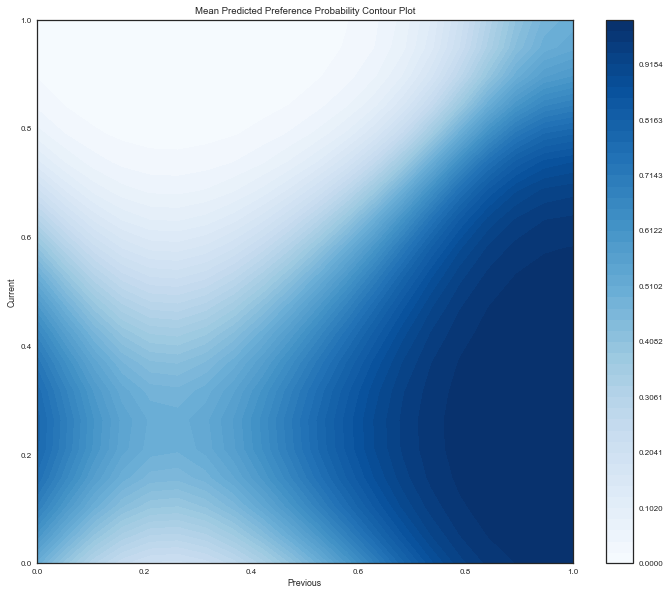

In [63]:
mean_levels = np.linspace(0,1.)
plt.figure(figsize=(12,10))
mean_reshape = p[2,:].reshape((num_grid, num_grid), order='F')
c = plt.contourf(Xt1,Xt1,mean_reshape.T,
                 mean_levels, cmap=plt.cm.Blues)
plt.colorbar(c)
plt.xlabel('Previous')
plt.ylabel('Current')
plt.title('Mean Predicted Preference Probability Contour Plot')

## Occupant 1

In [20]:
var_list[0].shape

(800, 1)